In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback, get_scheduler
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.optim as optim
import numpy as np

# Load a custom CSV file
data_files = {"train": "train_test_datasets/train_balanced.csv", "test": "train_test_datasets/test.csv"}
dataset = load_dataset("csv", data_files=data_files)

# -----------------------------------
# INITIAL INSPECTION
# -----------------------------------

# Inspect the first few samples
print(dataset["train"][0])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #NOTE: Using base model. Increase size for better performance
sample_text = "The purpose of this organization is to provide community services."
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print(tokens)

def tokenize_function(examples):
    return tokenizer(examples["mission"], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets["train"][0])

labels = dataset['train']['label']
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
print(class_weights)

c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'mission': 'home to home provides monitored child custody exchanges to protect children from potential instances of domestic violence and emtional trauma', 'label': 0, 'reason': 'The mission focuses on providing monitored child custody exchanges and addressing domestic violence, which are secular activities.'}
{'input_ids': [101, 1996, 3800, 1997, 2023, 3029, 2003, 2000, 3073, 2451, 2578, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [2]:
# -----------------------------------
# SETTING MODEL AND LABELS
# -----------------------------------

# Load model with binary classification head
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
print(model.config)
optimizer = optim.AdamW(model.parameters())

# Freeze all layers
for param in model.bert.parameters(): # encoder parameters
    param.requires_grad = False

# Unfreeze the 3 encoder layers
for name, param in model.bert.named_parameters():
    if any(f"layer.{i}." in name for i in range(9, 12)):  # unfreeze last 3 instead of just the head
        param.requires_grad = True

# Keep the classification head trainable, always
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Trainable parameters: 21265154


In [3]:
# -----------------------------------
# SETTING PARAMETERS FOR TRAINING
# -----------------------------------

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=500,
    fp16=True,
    # push_to_hub=True
)

In [5]:
# -----------------------------------
# SETTING CUSTOM TRAINER AND CE LOSS
# -----------------------------------
import torch.nn as nn
import torch

class_weights = np.array([1.0, 3.5]) # manually adapting class weights to increase class 1 identification. 3 for class 1 worked ok

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [6]:
# -----------------------------------
# TRAINING AND EVALUATION
# -----------------------------------

metric = load('f1') # accuracy does not work great for imbalanced datasets, f1 is better

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # This ensures that each batch is dynamically padded to the longest seq. in the batch

num_training_steps = len(tokenized_datasets["train"]) // training_args.per_device_train_batch_size
num_training_steps *= training_args.num_train_epochs

scheduler = get_scheduler( # this helps start with a small learning rate, increase it gradually and decay afterwards
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps # number of batches * number of epochs
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)



trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2)) # early stop to reach peak performance and avoid overfitting
trainer.train()
trainer.save_model("./my_model")

results = trainer.evaluate()
print(results)

C:\Users\rqg886\AppData\Local\Temp\ipykernel_18028\531096198.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.154419,0.197778,0.208333,0.116279,1.000000
2,No log,0.825874,0.576667,0.328042,0.197034,0.978947
3,0.366400,0.190306,0.954444,0.811060,0.721311,0.926316
4,0.366400,0.201722,0.961111,0.830918,0.767857,0.905263
5,0.182000,0.202172,0.958889,0.824645,0.750000,0.915789


c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used

{'eval_loss': 0.1903056502342224, 'eval_accuracy': 0.9544444444444444, 'eval_f1': 0.8110599078341014, 'eval_precision': 0.7213114754098361, 'eval_recall': 0.9263157894736842, 'eval_runtime': 42.7, 'eval_samples_per_second': 21.077, 'eval_steps_per_second': 1.335, 'epoch': 5.0}


c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0       0.99      0.91      0.95       805
           1       0.56      0.95      0.70        95

    accuracy                           0.91       900
   macro avg       0.77      0.93      0.83       900
weighted avg       0.95      0.91      0.92       900



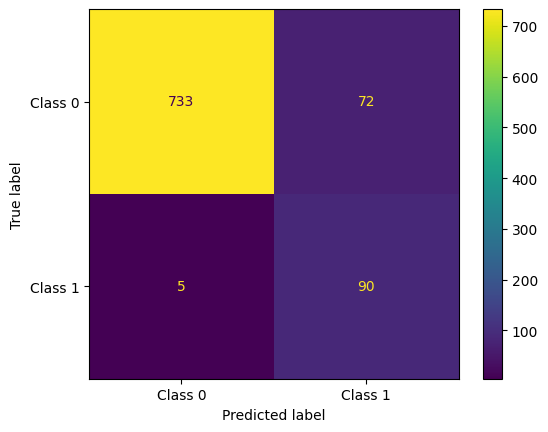

In [42]:
# -----------------------------------
# CLASSIFICATION REPORT AND CONFUSION MATRIX
# -----------------------------------

# Generate predictions
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot();

In [43]:
for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_datasets["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(tokenized_datasets["test"][idx]["mission"])

Index: 2, Predicted: 1, Actual: 0
charitable support
Index: 3, Predicted: 0, Actual: 1
committed to providing a holistic learning community which encourages the growth of mind body and spirit and which is actively involved in the local and global community
Index: 38, Predicted: 1, Actual: 0
the entity merged with another non profit agency as of 7/1/11 the merged entity operates under ein 01-0217639
Index: 41, Predicted: 1, Actual: 0
the y is a powerful association of men women and children of all ages and from all walks of life joined together by a shared passion: to strengthen the foundation of community with a commitment to nurturing the potential of kids promoting healthy living and fostering a sense of social responsibility the y ensures that every individual has access to the essentials needed to learn grow and thrive anchored in more than 10000 neighborhoods around the country the y has the long standing relationships and physical presence not just to promise but to deliver lasti